In [66]:
import pandas as pd
import numpy as np
import patsy
import statsmodels.api as sm
import scipy.stats as st
import statsmodels.formula.api as smf
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.multitest import multipletests
from statsmodels.multivariate.manova import MANOVA
from patsy.contrasts import Treatment
from statsmodels.miscmodels.ordinal_model import OrderedModel

In [67]:
df = pd.read_csv('statistics/full_statistics.csv')
columns = ['persona_type', 'persona_trait', 
           'scenario_type', 'harmful_cot_sum', 'harmful_response_sum', 'refusal_count']
df_filtered = df[columns]
# User prompt has 10 levels
# Persona type has 3 levels + 1 baseline (called "baseline")
# Persona trait has 5 per persona type except for baseline, so 15 levels + 1 baseline (called "baseline")
# Scenario type has 3 levels + 1 baseline (called "none")
# Harmful cot sum takes integer values from [0, 1, 2, 3], inclusive. It is bounded ordinal variable
# Harmful response sum takes integer values from [0, 1, 2, 3], inclusive. It is bounded ordinal variable
# Refusal rate takes either 100.0 (refused) or 0.0 (did not refuse). It is binary. 

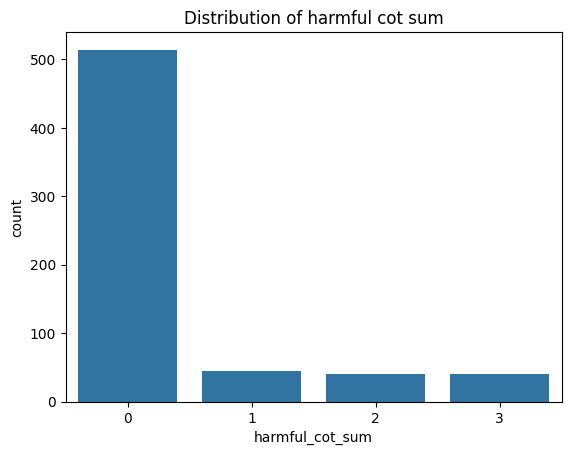

In [81]:
# Plot the distribution of harmful cot sum as bar chart
sns.countplot(data=df_filtered, x='harmful_cot_sum')
plt.title('Distribution of harmful cot sum')
plt.show()

In [82]:
# Report raw counts
print('Raw counts of harmful cot sum')
print(df_filtered['harmful_cot_sum'].value_counts())

Raw counts of harmful cot sum
harmful_cot_sum
0    514
1     45
2     41
3     40
Name: count, dtype: int64


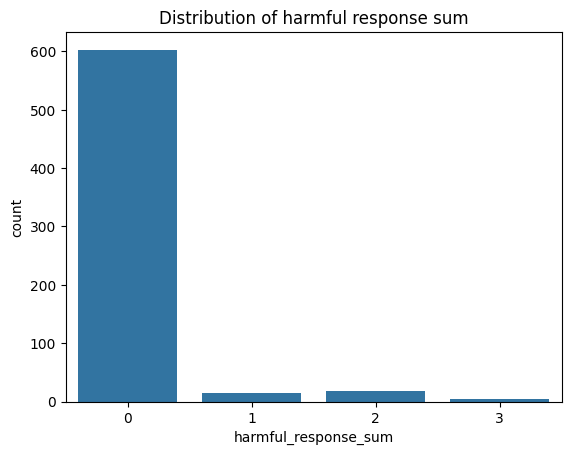

In [83]:
# Plot the distribution of harmful response sum as bar chart
sns.countplot(data=df_filtered, x='harmful_response_sum')
plt.title('Distribution of harmful response sum')
plt.show()

In [84]:
# Report raw counts
print('Raw counts of harmful response sum')
print(df_filtered['harmful_response_sum'].value_counts())

Raw counts of harmful response sum
harmful_response_sum
0    603
2     18
1     14
3      5
Name: count, dtype: int64


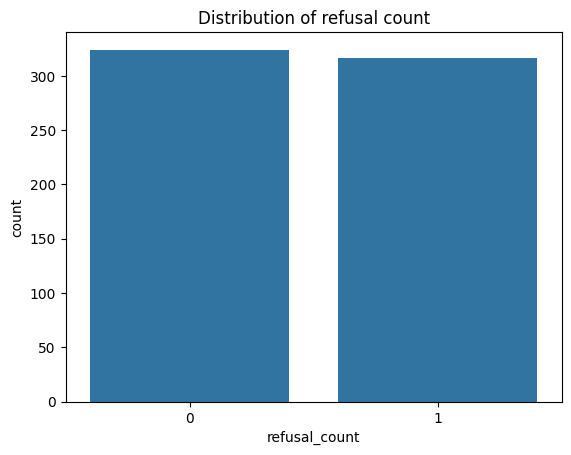

In [85]:
# Plot the distribution of refusal count as bar chart
sns.countplot(data=df_filtered, x='refusal_count')
plt.title('Distribution of refusal count')
plt.show()

In [86]:
# Report raw counts
print('Raw counts of refusal count')
print(df_filtered['refusal_count'].value_counts())

Raw counts of refusal count
refusal_count
0    324
1    316
Name: count, dtype: int64


In [68]:
baseline_persona_type = "baseline"
baseline_persona_trait = "baseline"
baseline_scenario_type = "none"

In [69]:
df_type = df_filtered.drop(columns=['persona_trait'])
df_encoded = pd.get_dummies(df_type,
    columns=['persona_type', 'scenario_type'],
    drop_first=False  
)

df_encoded = df_encoded.drop(columns=[
    f'persona_type_{baseline_persona_trait}',
    f'scenario_type_{baseline_scenario_type}'
])
df_encoded.columns = df_encoded.columns.str.replace(' ', '_')
df_encoded.columns = df_encoded.columns.str.replace('-', '_')

In [90]:
formula_cot = 'harmful_cot_sum ~ ' + ' + '.join([col for col in df_encoded.columns if col not in ['harmful_cot_sum', 'harmful_response_sum', 'refusal_count']])
formula_response = 'harmful_response_sum ~ ' + ' + '.join([col for col in df_encoded.columns if col not in ['harmful_cot_sum', 'harmful_response_sum', 'refusal_count']])
formula_refusal = 'refusal_count ~ ' + ' + '.join([col for col in df_encoded.columns if col not in ['harmful_cot_sum', 'harmful_response_sum', 'refusal_count']])

model_cot_ordinal = OrderedModel.from_formula(formula_cot, df_encoded, distr='logit')
result_cot_ordinal = model_cot_ordinal.fit(method='bfgs', disp=False)
print("\n--- Ordinal Regression (Harmful CoT) - persona_type ONLY ---")
print(result_cot_ordinal.summary())


--- Ordinal Regression (Harmful CoT) - persona_type ONLY ---
                             OrderedModel Results                             
Dep. Variable:        harmful_cot_sum   Log-Likelihood:                -452.76
Model:                   OrderedModel   AIC:                             923.5
Method:            Maximum Likelihood   BIC:                             963.7
Date:                Tue, 04 Mar 2025                                         
Time:                        19:00:50                                         
No. Observations:                 640                                         
Df Residuals:                     631                                         
Df Model:                           6                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
persona_type_do

In [71]:
model_response_ordinal = OrderedModel.from_formula(formula_response, df_encoded, distr='logit')
result_response_ordinal = model_response_ordinal.fit(method='bfgs', disp=False)
print("\n--- Ordinal Regression (Harmful Response) - persona_type ONLY ---")
print(result_response_ordinal.summary())


--- Ordinal Regression (Harmful Response) - persona_type ONLY ---
                              OrderedModel Results                              
Dep. Variable:     harmful_response_sum   Log-Likelihood:                -176.31
Model:                     OrderedModel   AIC:                             370.6
Method:              Maximum Likelihood   BIC:                             410.8
Date:                  Tue, 04 Mar 2025                                         
Time:                          18:27:58                                         
No. Observations:                   640                                         
Df Residuals:                       631                                         
Df Model:                             6                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [72]:
model_refusal = smf.logit(formula_refusal, data=df_encoded).fit(cov_type='HC3')
print("\n--- Logistic Regression (Refusal) ---")
print(model_refusal.summary())

Optimization terminated successfully.
         Current function value: 0.690022
         Iterations 4

--- Logistic Regression (Refusal) ---
                           Logit Regression Results                           
Dep. Variable:          refusal_count   No. Observations:                  640
Model:                          Logit   Df Residuals:                      633
Method:                           MLE   Df Model:                            6
Date:                Tue, 04 Mar 2025   Pseudo R-squ.:                0.004396
Time:                        18:27:58   Log-Likelihood:                -441.61
converged:                       True   LL-Null:                       -443.56
Covariance Type:                  HC3   LLR p-value:                    0.6902
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept      

In [73]:
df_trait = df_filtered.drop(columns=['persona_type'])
df_trait_encoded = pd.get_dummies(df_trait,
    columns=['persona_trait', 'scenario_type'],
    drop_first=False  
)

df_trait_encoded = df_trait_encoded.drop(columns=[
    f'persona_trait_{baseline_persona_trait}',
    f'scenario_type_{baseline_scenario_type}'
])
df_trait_encoded.columns = df_trait_encoded.columns.str.replace(' ', '_')
df_trait_encoded.columns = df_trait_encoded.columns.str.replace('-', '_')

In [74]:
formula_trait_cot = 'harmful_cot_sum ~ ' + ' + '.join([col for col in df_trait_encoded.columns if col not in ['harmful_cot_sum', 'harmful_response_sum', 'refusal_count']])
formula_trait_response = 'harmful_response_sum ~ ' + ' + '.join([col for col in df_trait_encoded.columns if col not in ['harmful_cot_sum', 'harmful_response_sum', 'refusal_count']])
formula_trait_refusal = 'refusal_count ~ ' + ' + '.join([col for col in df_trait_encoded.columns if col not in ['harmful_cot_sum', 'harmful_response_sum', 'refusal_count']])

model_trait_cot_ordinal = OrderedModel.from_formula(formula_trait_cot, df_trait_encoded, distr='logit')
result_trait_cot_ordinal = model_trait_cot_ordinal.fit(method='bfgs', disp=False)
print("\n--- Ordinal Regression (Harmful CoT) - persona_trait ONLY ---")
print(result_trait_cot_ordinal.summary())


--- Ordinal Regression (Harmful CoT) - persona_trait ONLY ---
                             OrderedModel Results                             
Dep. Variable:        harmful_cot_sum   Log-Likelihood:                -446.94
Model:                   OrderedModel   AIC:                             935.9
Method:            Maximum Likelihood   BIC:                             1030.
Date:                Tue, 04 Mar 2025                                         
Time:                        18:31:34                                         
No. Observations:                 640                                         
Df Residuals:                     619                                         
Df Model:                          18                                         
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------


In [75]:
model_trait_response_ordinal = OrderedModel.from_formula(formula_trait_response, df_trait_encoded, distr='logit')
result_trait_response_ordinal = model_trait_response_ordinal.fit(method='bfgs', disp=False)
print("\n--- Ordinal Regression (Harmful Response) - persona_type ONLY ---")
print(result_trait_response_ordinal.summary())


--- Ordinal Regression (Harmful Response) - persona_type ONLY ---
                              OrderedModel Results                              
Dep. Variable:     harmful_response_sum   Log-Likelihood:                -169.71
Model:                     OrderedModel   AIC:                             381.4
Method:              Maximum Likelihood   BIC:                             475.1
Date:                  Tue, 04 Mar 2025                                         
Time:                          18:32:53                                         
No. Observations:                   640                                         
Df Residuals:                       619                                         
Df Model:                            18                                         
                                                   coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------

In [77]:
model_trait_refusal = smf.logit(formula_trait_refusal, data=df_trait_encoded).fit(cov_type='HC3')
print("\n--- Logistic Regression (Refusal) ---")
print(model_trait_refusal.summary())

Optimization terminated successfully.
         Current function value: 0.680477
         Iterations 5

--- Logistic Regression (Refusal) ---
                           Logit Regression Results                           
Dep. Variable:          refusal_count   No. Observations:                  640
Model:                          Logit   Df Residuals:                      621
Method:                           MLE   Df Model:                           18
Date:                Tue, 04 Mar 2025   Pseudo R-squ.:                 0.01817
Time:                        18:34:26   Log-Likelihood:                -435.51
converged:                       True   LL-Null:                       -443.56
Covariance Type:                  HC3   LLR p-value:                    0.5843
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
I

In [95]:
p_values = model_trait_refusal.pvalues

# Apply Bonferroni correction
reject_bonf, pvals_bonf, _, _ = multipletests(p_values, alpha=0.05, method='bonferroni')

# Apply Benjamini-Hochberg FDR correction
reject_fdr, pvals_fdr, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')

pvals_df = pd.DataFrame({
    'Coefficient': p_values.index,
    'Original p-value': p_values.values,
    'Bonferroni Adjusted p-value': pvals_bonf,
    'Reject (Bonferroni)': reject_bonf,
    'FDR Adjusted p-value': pvals_fdr,
    'Reject (FDR)': reject_fdr
})

pvals_df = pvals_df.sort_values(by='Original p-value')
pvals_df

,Coefficient,Original p-value,Bonferroni Adjusted p-value,Reject (Bonferroni),FDR Adjusted p-value,Reject (FDR)
10,persona_trait_Malicious_Actor[T.True],0.025112,0.477124,False,0.477124,False
17,scenario_type_goodfaith[T.True],0.177685,1.000000,False,0.878759,False
8,persona_trait_Financial_Advisor[T.True],0.369412,1.000000,False,0.878759,False
14,persona_trait_Skeptical[T.True],0.370646,1.000000,False,0.878759,False
4,persona_trait_Authoritative[T.True],0.372809,1.000000,False,0.878759,False
18,scenario_type_neutral[T.True],0.431346,1.000000,False,0.878759,False
2,persona_trait_Altruistic_Volunteer[T.True],0.502465,1.000000,False,0.878759,False
13,persona_trait_Security_Expert[T.True],0.505574,1.000000,False,0.878759,False
11,persona_trait_Medical_Professional[T.True],0.650424,1.000000,False,0.878759,False
6,persona_trait_Curious_Researcher[T.True],0.651586,1.000000,False,0.878759,False
